# Handout #4: Unsupervised Learning (hierarchical clustering)

## Problem 5

Load needed libraries

In [82]:
import numpy as np

### Load the *dataset*

Our group is '01'

In [83]:
group = '01'  # BERNAT LADARIA, Lluís
ds = 5

Load vectors from file

In [84]:
data = np.loadtxt('ds'+group+str(ds)+'.txt')

Split data and labels

In [85]:
X = data[:, 0:2]
y = data[:, 2]

How many vectors we have to classify?

In [86]:
X.shape

(1000, 2)

How many classes?

In [220]:
y_classes = np.unique(y)
y_classes

array([0., 1., 2.])

We have a 3 classes classification problem

### Cluster the data

Import necessary functions and classes

In [88]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import v_measure_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

In [204]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as col

Create the options lists to use

In [90]:
linkage_list = ['complete', 'average', 'ward']

In [91]:
n_clusters_list = [2, 3, 4, 5]

In [92]:
affinity_list = ['euclidean']

Prepare a models list and populate it with all the trials results

In [243]:
models_list = list()

for linkage, n_clusters, affinity in itertools.product(linkage_list, n_clusters_list, affinity_list):
    model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters, affinity=affinity)
    model.fit(X)
    
    entry = {
        'linkage': linkage,
        'n_clusters': n_clusters,
        'affinity': affinity,
        'model': model, 
        'v_measure_score': v_measure_score(labels_true=y, labels_pred=model.labels_),
        'davies_bouldin_score': davies_bouldin_score(X=X, labels=model.labels_)
    }
    models_list.append(entry)

Determine the best model for each algorithm (linkage)

The v_measure scores into a \[0 ,1\] interval the similarity between real and predicted labels.
A value near 1, denotes a good classification. The zero value is the worst case.

So we must lookup for the **maximum v_measure_score value** case for each algorithm.

In [244]:
best_v_measure_dict = {}
best_davies_bouldin_dict = {}

for model in models_list:
    t = model['linkage']
    if t not in best_v_measure_dict or model['v_measure_score'] > best_v_measure_dict.get(t)['v_measure_score']:
        best_v_measure_dict[t] = model
    if t not in best_davies_bouldin_dict or model['davies_bouldin_score'] < best_davies_bouldin_dict.get(t)['davies_bouldin_score']:
        best_davies_bouldin_dict[t] = model

### V-measure score

In [245]:
best_v_measure_list = list(best_v_measure_dict.values())
best_v_measure_list

[{'linkage': 'complete',
  'n_clusters': 3,
  'affinity': 'euclidean',
  'model': AgglomerativeClustering(linkage='complete', n_clusters=3),
  'v_measure_score': 0.943473573294366,
  'davies_bouldin_score': 0.4971891054409023},
 {'linkage': 'average',
  'n_clusters': 4,
  'affinity': 'euclidean',
  'model': AgglomerativeClustering(linkage='average', n_clusters=4),
  'v_measure_score': 0.9439785661193727,
  'davies_bouldin_score': 0.6888499606015155},
 {'linkage': 'ward',
  'n_clusters': 3,
  'affinity': 'euclidean',
  'model': AgglomerativeClustering(n_clusters=3),
  'v_measure_score': 0.9434735732943661,
  'davies_bouldin_score': 0.4971891054409023}]

In short, the best V-measure score indicates that: 

- the best score for *complete-linkage* and *ward* algorithms is the **3 clusters** case
- the best score for *average-linkage* is a **4 cluters** classification

Now will select the best one according to the V_measure score

In [96]:
best_v_measure_model = None

for model in models_list:
    if best_v_measure_model is None or model['v_measure_score'] > best_v_measure_model['v_measure_score']:
        best_v_measure_model = model

In [97]:
best_v_measure_model

{'linkage': 'average',
 'n_clusters': 4,
 'affinity': 'euclidean',
 'model': AgglomerativeClustering(linkage='average', n_clusters=4),
 'v_measure_score': 0.9439785661193727}

It seems that the best V-measure scored case is the one with 4 clusters, using the *average-linkage* function

To visualize the clustering results, will plot the samples, first with original labels and then with the new *best* labels

We will calculate the maximum and minimum class values to get same color tones when plotting

In [225]:
y_best_v_measure_model_labels = best_v_measure_model['model'].labels_

plot_vmax=max(max(y_best_v_measure_model_labels), max(y_classes))
plot_vmin=min(min(y_best_v_measure_model_labels), min(y_classes))
print("range:", plot_vmin, plot_vmax)

range: 0 3


Plotting data with original labels

Create an *ad-hoc* cmap (rgb hex list) for a better representation

In [209]:
paleta = col.LinearSegmentedColormap.from_list(
        'my_colors', ['#000000', '#ff0000', '#00ff00', '#0000ff'])

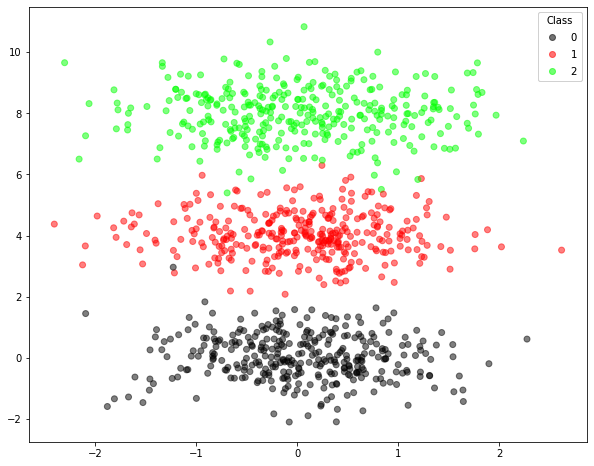

In [239]:
_, ax = plt.subplots(figsize=(10,8))

scatter = ax.scatter(x=X[:,0], y=X[:,1], c=y, alpha=0.5, cmap=paleta, vmin=plot_vmin, vmax=plot_vmax)
my_legend = ax.legend(*scatter.legend_elements(),
                      loc="upper right", title="Class")
ax.add_artist(my_legend)

It seems that there are only three classes (with some outlier values)

Now we plot the *best* cassification obtained from best V-measure scoring

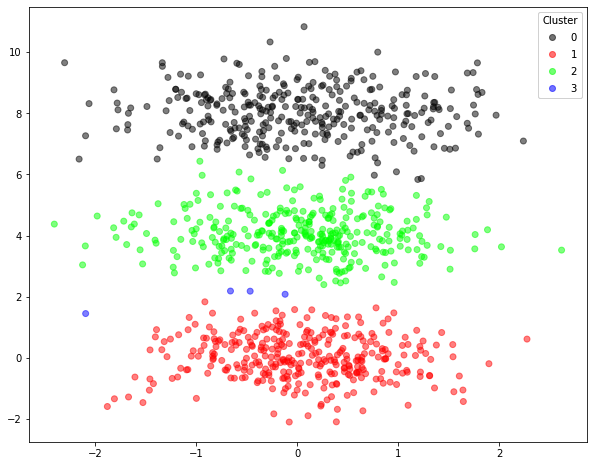

In [240]:
_, ax = plt.subplots(figsize=(10,8))

scatter = ax.scatter(x=X[:,0], y=X[:,1], c=y_best_v_measure_model_labels, alpha=0.5, cmap=paleta, vmin=plot_vmin, vmax=plot_vmax)
my_legend = ax.legend(*scatter.legend_elements(),
                      loc="upper right", title="Cluster")
ax.add_artist(my_legend)

Ummm, it seems that the *average* algorithm doesn't provide the correct clusters number.
Also the new *4th cluster* is formed by four outlier values. 
And other *border or outlier samples* are missclassified.

The contingency table will tell us more details

In [101]:
best_v_measure_model_contingency_matrix = contingency_matrix(labels_true=y, labels_pred=y_best_v_measure_model_labels)
best_v_measure_model_contingency_matrix

array([[  0, 332,   1,   1],
       [  2,   0, 328,   3],
       [327,   0,   6,   0]])

In [202]:
def pretty_print_cm(cm: np.ndarray, true_labels: list):
    line = '          '
    for j in range(1, cm.shape[1] + 1):
        line = line + (' Cluster {:2}'.format(j))
    print(line)
    for i, row in enumerate(cm):
        line = 'Class {:2}: '.format(int(true_labels[i])) + ''.join(''.join(['{:11}'.format(element) for element in row]))
        print(line)

In [241]:
pretty_print_cm(best_v_measure_model_contingency_matrix, y_classes)

           Cluster  1 Cluster  2 Cluster  3 Cluster  4
Class  0:           0        332          1          1
Class  1:           2          0        328          3
Class  2:         327          0          6          0


As seen in contingency table (looking up for the top values) the assignment of classes is as follows:

- Class 0 has been assigned to cluster 2
- Class 1 has been assigned to cluster 3
- Class 2 has been assigned to cluster 1

We can summarize the clustering errors as:

- Class 0 has 2 missclassified samples. One of them will be part of the *new* 4th cluster
- Class 1 has 5 missclassified samples. Three of them at 4th cluster
- Class 2 its the one with more missclassified samples. It has 6 samples assigned to 3rd cluster

### Davies-Bouldin score

In [247]:
best_davies_bouldin_list = list(best_davies_bouldin_dict.values())
best_davies_bouldin_list

[{'linkage': 'complete',
  'n_clusters': 3,
  'affinity': 'euclidean',
  'model': AgglomerativeClustering(linkage='complete', n_clusters=3),
  'v_measure_score': 0.943473573294366,
  'davies_bouldin_score': 0.4971891054409023},
 {'linkage': 'average',
  'n_clusters': 3,
  'affinity': 'euclidean',
  'model': AgglomerativeClustering(linkage='average', n_clusters=3),
  'v_measure_score': 0.9397450891215053,
  'davies_bouldin_score': 0.4985242485963006},
 {'linkage': 'ward',
  'n_clusters': 3,
  'affinity': 'euclidean',
  'model': AgglomerativeClustering(n_clusters=3),
  'v_measure_score': 0.9434735732943661,
  'davies_bouldin_score': 0.4971891054409023}]

Top Davies-Bouldin score podium indicates that: 

- the *complete-linkage* and *ward* algorithms have the same best score. Both signaling a **3 clusters** partition
- the *average-linkage* has the second place in the podium. Also a **3 cluster** partition

Now will select the best one according to the V_measure score (the first top score in the dictionary order)

In [250]:
best_davies_bouldin_model = None

for model in models_list:
    if best_davies_bouldin_model is None or model['davies_bouldin_score'] < best_davies_bouldin_model['davies_bouldin_score']:
        best_davies_bouldin_model = model

In [251]:
best_davies_bouldin_model

{'linkage': 'complete',
 'n_clusters': 3,
 'affinity': 'euclidean',
 'model': AgglomerativeClustering(linkage='complete', n_clusters=3),
 'v_measure_score': 0.943473573294366,
 'davies_bouldin_score': 0.4971891054409023}

To visualize the clustering results, will plot the samples, first with original labels and then with the new *best* labels

We will calculate the maximum and minimum class values to get same color tones when plotting

In [253]:
y_best_davies_bouldin_model_labels = best_davies_bouldin_model['model'].labels_

plot_vmax=max(max(y_best_davies_bouldin_model_labels), max(y_classes))
plot_vmin=min(min(y_best_davies_bouldin_model_labels), min(y_classes))
print("range:", plot_vmin, plot_vmax)

range: 0 2


Plotting data with original labels

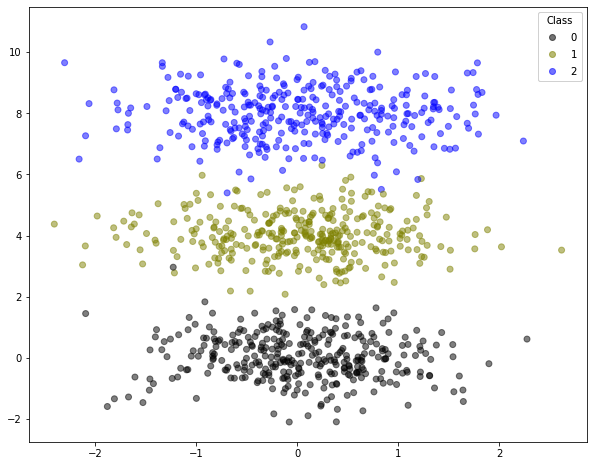

In [254]:
_, ax = plt.subplots(figsize=(10,8))

scatter = ax.scatter(x=X[:,0], y=X[:,1], c=y, alpha=0.5, cmap=paleta, vmin=plot_vmin, vmax=plot_vmax)
my_legend = ax.legend(*scatter.legend_elements(),
                      loc="upper right", title="Class")
ax.add_artist(my_legend)

As we already know, there are only three classes (with some outlier values)

Now we plot the *best* cassification obtained from best Davies-Bouldin scoring

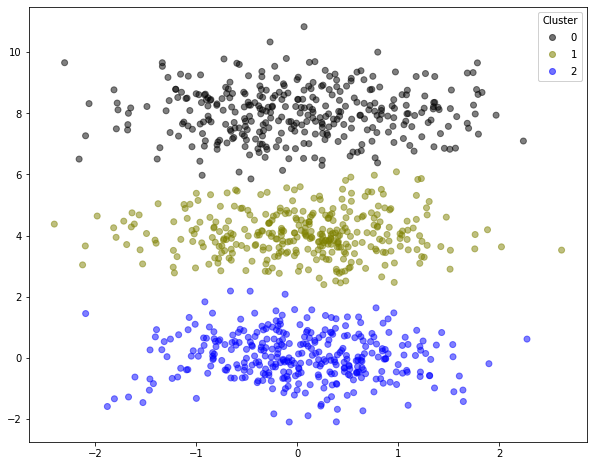

In [257]:
_, ax = plt.subplots(figsize=(10,8))

scatter = ax.scatter(x=X[:,0], y=X[:,1], c=y_best_davies_bouldin_model_labels, alpha=0.5, cmap=paleta, vmin=plot_vmin, vmax=plot_vmax)
my_legend = ax.legend(*scatter.legend_elements(),
                      loc="upper right", title="Cluster")
ax.add_artist(my_legend)

Ummm, it seems that there are some missclassified *border or outlier samples*

The contingency table will tell us more details

In [258]:
best_davies_bouldin_model_contingency_matrix = contingency_matrix(labels_true=y, labels_pred=y_best_davies_bouldin_model_labels)
best_davies_bouldin_model_contingency_matrix

array([[  0,   1, 333],
       [  2, 328,   3],
       [328,   5,   0]])

In [259]:
pretty_print_cm(best_davies_bouldin_model_contingency_matrix, y_classes)

           Cluster  1 Cluster  2 Cluster  3
Class  0:           0          1        333
Class  1:           2        328          3
Class  2:         328          5          0


As seen in contingency table (looking up for the top values) the assignment of classes is as follows:

- Class 0 has been assigned to cluster 3
- Class 1 has been assigned to cluster 2
- Class 2 has been assigned to cluster 1

We can summarize the clustering errors as:

- Class 0 has 1 missclassified sample
- Class 1 has 5 missclassified samples
- Class 2 also has 5 missclassified samples

### Conclussions

TODO

## Problem 6